# Demonstration: Protecting Gradients Using Shamir Secret Sharing

In this notebook, we demonstrate how to use Shamir Secret Sharing to protect the gradients computed during training in a neural network, specifically in the context of federated learning. We will:

- Train a simple neural network on the MNIST dataset
- Compute gradients from several images
- Demonstrate an attack that attempts to reconstruct some inputs from the gradients
- Apply Shamir Secret Sharing to protect the gradients
- Show how the attack fails on the protected gradients


## Load Libraries and Dataset
We begin by importing the necessary libraries.

In [1]:
%pip install torch
%pip install torchvision
%pip install matplotlib
import torch
import numpy as np
import matplotlib.pyplot as plt
import inversefed #Jonas Geiping et al.

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Define the Neural Network
We define a simple feedforward neural network that will be trained on the MNIST dataset. In principle, the attack works in both trained or untrained model. 

In [2]:
import torch.nn as nn

seed = np.random.randint(0, 2**32 - 10)
inversefed.nn.models.set_random_seed(seed)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


model = Net()


In [3]:
trained_model = False

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
model.device = device

In [4]:
setup = inversefed.utils.system_startup()
defs = inversefed.training_strategy('conservative')
defs.epochs = 1

loss_fn, trainloader, validloader =  inversefed.construct_dataloaders('MNIST', defs)

model.to(**setup)
if trained_model:
    epochs = defs.epochs
    file = 'MNIST_{epochs}.pth'
    try:
        model.load_state_dict(torch.load(f'models/{file}'))
    except FileNotFoundError:
        inversefed.train(model, loss_fn, trainloader, validloader, defs, setup=setup)
        torch.save(model.state_dict(), f'models/{file}')
model.eval();

dm = torch.as_tensor(inversefed.consts.mnist_mean, **setup)[:, None, None]
ds = torch.as_tensor(inversefed.consts.mnist_std, **setup)[:, None, None]

def plot(tensor):
    tensor = tensor.clone().detach()
    tensor.mul_(ds).add_(dm).clamp_(0, 1)
    if tensor.shape[0] == 1:
        return plt.imshow(tensor[0].permute(1, 2, 0).cpu());
    else:
        fig, axes = plt.subplots(1, tensor.shape[0], figsize=(12, tensor.shape[0]*12))
        for i, im in enumerate(tensor):
            axes[i].imshow(im.permute(1, 2, 0).cpu());

Currently evaluating -------------------------------:
Wednesday, 09. October 2024 12:33PM
CPUs: 6, GPUs: 1 on gpuvq.
GPU : Tesla V100-PCIE-16GB


## Image reconstruction using gradients

To reproduce the context of federated learning, we're going to compute gradients on a few images and we're going to pretend that these gradients are sent to a central server, except that the central server is supposedly corrupted: it's going to use these gradients to reconstruct the images that were used to create these gradients.

### Build the input (ground-truth) gradients

In [1]:
num_images = 10 # Number of images used to compute the gradients

In [5]:
ground_truth, labels = [], []
idx = 42 # choosen randomly
while len(labels) < num_images:
    img, label = validloader.dataset[idx]
    idx += 1
    labels.append(torch.as_tensor((label,), device=setup['device']))
    ground_truth.append(img.to(**setup))
ground_truth = torch.stack(ground_truth)
labels = torch.cat(labels)

['4 - four', '2 - two', '3 - three', '5 - five', '1 - one', '2 - two', '4 - four', '4 - four', '6 - six', '3 - three']


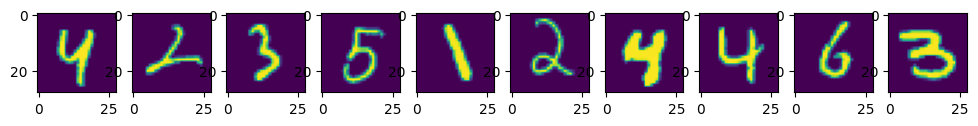

In [6]:
plot(ground_truth);
print([validloader.dataset.classes[l] for l in labels]);

In [7]:
model.zero_grad()
target_loss, _, _ = loss_fn(model(ground_truth), labels)
input_gradients = torch.autograd.grad(target_loss, model.parameters())

## Reconstruction algorithm

Applying the [reconstruction algorithm](https://arxiv.org/abs/2003.14053v1) and comparison with the ground truth images.

It: 0. Rec. loss: 0.9404.
It: 499. Rec. loss: 0.0458.
Choosing optimal result ...
Optimal result score: 0.0461
Total time: 4.086120843887329.
defaultdict(<class 'list'>, {'opt': 0.04609358310699463})


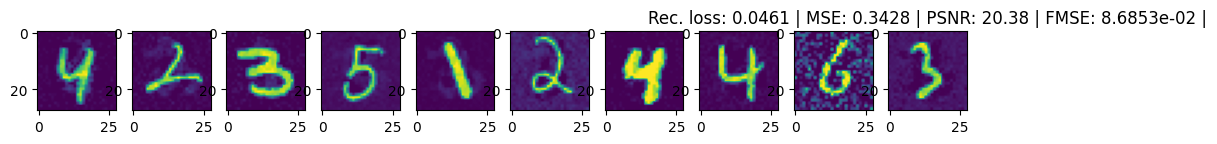

In [8]:
config = dict(signed=True,
              boxed=True,
              cost_fn='sim',
              indices='def',
              weights='equal',
              lr=1,
              optim='adam',
              restarts=1,
              max_iterations=500,
              total_variation=1e-6,
              init='randn',
              filter='none',
              lr_decay=True,
              scoring_choice='loss')

input_grad = [grad.detach() for grad in input_gradients]
rec_machine = inversefed.GradientReconstructor(model, (dm, ds), config, num_images=num_images)
output, stats = rec_machine.reconstruct(input_grad, labels, img_shape=(1, 28, 28))

test_mse = (output.detach() - ground_truth).pow(2).mean()
feat_mse = (model(output.detach())- model(ground_truth)).pow(2).mean()  
test_psnr = inversefed.metrics.psnr(output, ground_truth, factor=1/ds)

print(stats)
plot(output)
plt.title(f"Rec. loss: {stats['opt']:2.4f} | MSE: {test_mse:2.4f} "
          f"| PSNR: {test_psnr:4.2f} | FMSE: {feat_mse:2.4e} |");

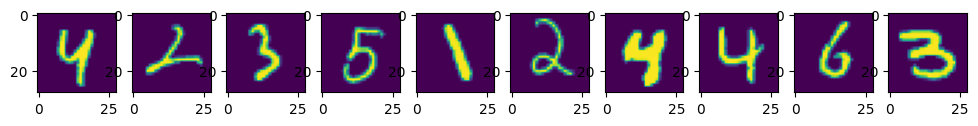

In [9]:
plot(ground_truth);

## Shamir secret sharing

The idea is to add to use Shamir secret sharing to prevent attacks on the gradients in the context of federated learning. This means that:
- the gradient is turned into shamir shares
- the single server aggregating the gradients would be replaced by several servers, each aggregating its shares: Shamir secret sharing scheme is additive homomorphic. 

Below, we define all the necessary functions to implement the Shamir secret sharing scheme.

In [10]:
p = 2**61 - 1  # Large prime number for finite field

# Scaling factor
SCALING_FACTOR = 1e6  # Scale floating-point gradients to preserve precision

DEVICE = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

def map_float_to_field(grad, p, scaling_factor):
    scaled = torch.round(grad * scaling_factor).to(torch.int64)
    return scaled % p

def map_field_to_float(grad_field, p, scaling_factor):
    grad_field = grad_field % p

    half_p = p // 2
    grad_field = torch.where(grad_field > half_p, grad_field - p, grad_field)

    return grad_field.float() / scaling_factor

def shamir_split_tensor(tensor, num_shares, threshold, p):
    shares_list = []
    
    for element in tensor.flatten():
        element = element.item()
        shares = shamir_split(element, num_shares, threshold, p)
        shares_list.append(shares)
    
    shares_tensor = []
    for i in range(num_shares):
        single_share = [share[i][1] for share in shares_list]  # Extract each i-th share for all elements
        shares_tensor.append(torch.tensor(single_share, dtype=torch.int64, device = DEVICE).reshape(tensor.shape))
    
    return shares_tensor

def shamir_split(secret, num_shares, threshold, p):
    coeffs = [secret] + [torch.randint(0, p, (1,)).item() for _ in range(threshold - 1)]
    
    shares = []
    for i in range(1, num_shares + 1):
        x = i
        y = sum([coeff * (x ** power) % p for power, coeff in enumerate(coeffs)]) % p
        shares.append((x, y))
    
    return shares

def lagrange_interpolate(x, x_s, y_s, p):
    def l(k, x_s, x, p):
        prod = 1
        for i in range(len(x_s)):
            if i != k:
                num = (x - x_s[i]) % p
                denom = (x_s[k] - x_s[i]) % p
                denom_inv = pow(denom, -1, p)  # Modular inverse
                prod = (prod * num * denom_inv) % p
        return prod

    result = 0
    for k in range(len(x_s)):
        result = (result + y_s[k] * l(k, x_s, x, p)) % p
    return result

def shamir_reconstruct_tensor(shares_tensor, threshold, p):
    num_shares = len(shares_tensor)
    tensor_shape = shares_tensor[0].shape
    flattened_shares = [share.flatten() for share in shares_tensor]
    
    reconstructed_elements = []
    
    for i in range(flattened_shares[0].shape[0]):
        shares = [(j + 1, flattened_shares[j][i].item()) for j in range(threshold)]
        reconstructed_element = shamir_reconstruct(shares, p)
        reconstructed_elements.append(reconstructed_element)
    
    reconstructed_tensor = torch.tensor(reconstructed_elements, dtype=torch.int64, device=DEVICE).reshape(tensor_shape)
    
    return reconstructed_tensor

def shamir_reconstruct(shares, p):
    x_s, y_s = zip(*shares)
    return lagrange_interpolate(0, x_s, y_s, p)

def shamir_split_list_of_tensors(tensor_list, num_shares, threshold, p):
    shares_list_of_tensors = []

    for tensor in tensor_list:
        shares = shamir_split_tensor(tensor, num_shares, threshold, p)
        shares_list_of_tensors.append(shares)

    return shares_list_of_tensors

def shamir_reconstruct_list_of_tensors(shares_list_of_tensors, threshold, p):
    reconstructed_list = []

    for shares_tensor in shares_list_of_tensors:
        reconstructed_tensor = shamir_reconstruct_tensor(shares_tensor[:threshold], threshold, p)
        reconstructed_list.append(reconstructed_tensor)

    return reconstructed_list

def replace_with_shamir_share(input_gradients, num_shares, threshold, p):
    mapped_gradients = [map_float_to_field(grad, p, SCALING_FACTOR) for grad in input_gradients]
    shares_list_of_tensors = shamir_split_list_of_tensors(mapped_gradients, num_shares, threshold, p)
    replaced_tensors = [shares[0] for shares in shares_list_of_tensors]  # Pick the first share from each tensor
    return replaced_tensors


# Example of using the functions
gradient_tensor = torch.tensor([[-1.23, 0.9997, -03.5], [14.2, 0.88, -1.45]], device=device)

mapped_tensor = map_float_to_field(gradient_tensor, p, SCALING_FACTOR)

num_shares = 5   # Total number of shares
threshold = 3    # Minimum number of shares needed to reconstruct
shares_tensor = shamir_split_tensor(mapped_tensor, num_shares, threshold, p)

reconstructed_tensor = shamir_reconstruct_tensor(shares_tensor[:threshold], threshold, p)

final_reconstructed_tensor = map_field_to_float(reconstructed_tensor, p, SCALING_FACTOR)

# Verify the reconstruction matches the original tensor
assert torch.allclose(gradient_tensor, final_reconstructed_tensor, atol=1e-5), "Reconstructed tensor does not match the original!"
print("\nReconstruction was successful!")



Reconstruction was successful!


## Replacing the gradients by shamir shares

In [11]:
num_shares = 3   # Total number of shares
threshold = 2    # Minimum number of shares needed to reconstruct
share_gradients = replace_with_shamir_share(input_gradients, num_shares, threshold, p)

In [12]:
shares_grad_f = []
for grad_field in share_gradients:
    grad_field_f = map_field_to_float(grad_field, p, SCALING_FACTOR)
    shares_grad_f.append(grad_field_f)

## Reconstruction algorithm on share gradients

Applying the [reconstruction algorithm](https://arxiv.org/abs/2003.14053v1) on a share gradients.

It: 0. Rec. loss: 0.9989.
It: 499. Rec. loss: 0.7905.
Choosing optimal result ...
Optimal result score: 0.7886
Total time: 2.8739840984344482.


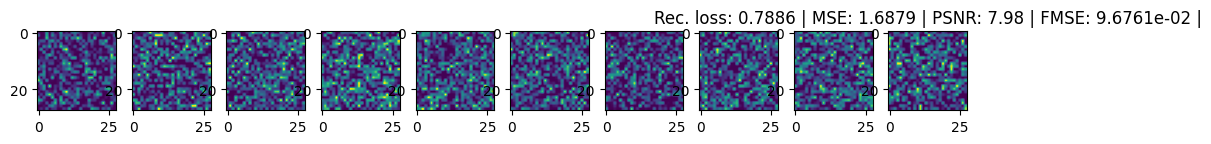

In [16]:
config = dict(signed=True,
              boxed=True,
              cost_fn='sim',
              indices='def',
              weights='equal',
              lr=1,
              optim='adam',
              restarts=1,
              max_iterations=500,
              total_variation=1e-6,
              init='randn',
              filter='none',
              lr_decay=True,
              scoring_choice='loss')

share_gradients = [grad.detach() for grad in shares_grad_f]
#share_gradients = [grad.detach() for grad in share_gradients]
rec_machine = inversefed.GradientReconstructor(model, (dm, ds), config, num_images=num_images)
output, stats = rec_machine.reconstruct(share_gradients, labels, img_shape=(1, 28, 28))

test_mse = (output.detach() - ground_truth).pow(2).mean()
feat_mse = (model(output.detach())- model(ground_truth)).pow(2).mean()  
test_psnr = inversefed.metrics.psnr(output, ground_truth, factor=1/ds)

plot(output)
plt.title(f"Rec. loss: {stats['opt']:2.4f} | MSE: {test_mse:2.4f} "
          f"| PSNR: {test_psnr:4.2f} | FMSE: {feat_mse:2.4e} |");

Shamir's secret sharing has protected the gradients from this type of attack.